# Introduction to LCEL and LangGraph: LangChain Powered RAG

In the following notebook we're going to focus on learning how to navigate and build useful applications using LangChain, specifically LCEL, and how to integrate different APIs together into a coherent RAG application!

We'll be building a RAG system to answer questions about how people use AI, using the "How People Use AI" dataset.

In the notebook, you'll complete the following Tasks:

- 🤝 Breakout Room #2:
    1. LangChain and LCEL Concepts
    2. Understanding States and Nodes
    3. Introduction to QDrant Vector Databases
    4. Building a Basic Graph

Let's get started!



## Installation Requirements

Also, make sure Ollama is installed and running with the required models pulled (see instructions below).


## Optional: LangSmith Setup for Tracing and Monitoring

LangSmith provides powerful tracing, monitoring, and debugging capabilities for LangChain applications. While not required for this notebook, setting it up will give you valuable insights into your RAG system's performance.

### Getting LangSmith Credentials

1. **Sign up for LangSmith**: Visit [smith.langchain.com](https://smith.langchain.com) and create a free account
2. **Get your API Key**: 
   - Go to Settings → API Keys
   - Create a new API key and copy it
3. **Set your environment variables** (choose one method below):

**Option A: Set environment variables in your terminal before starting Jupyter:**
```bash
export LANGCHAIN_TRACING_V2=true
export LANGCHAIN_API_KEY="your-api-key-here"
export LANGCHAIN_PROJECT="RAG-Assignment"
```

**Option B: Set them in the notebook (run the cell below):**


In [1]:
# Optional: Set up LangSmith tracing
# Uncomment and fill in your credentials if you want to use LangSmith

import os
import getpass

# Uncomment the lines below to enable LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
os.environ["LANGCHAIN_PROJECT"] = "RAG-Assignment"

#Verify setup (uncomment to check)
print("LangSmith tracing enabled:", os.getenv("LANGCHAIN_TRACING_V2", "false"))
print("Project name:", os.getenv("LANGCHAIN_PROJECT", "Not set"))


LangSmith tracing enabled: true
Project name: RAG-Assignment


### What LangSmith Provides

Once set up, LangSmith will automatically trace your LangChain operations and provide:

- **Execution traces**: See exactly how your RAG pipeline processes each query
- **Performance metrics**: Monitor latency, token usage, and costs
- **Debugging tools**: Inspect intermediate outputs at each step
- **Error tracking**: Identify and debug issues in your chains
- **Dataset management**: Collect and organize your queries and responses

You can view all traces and analytics in your LangSmith dashboard at [smith.langchain.com](https://smith.langchain.com).

> **Note**: LangSmith is completely optional for this assignment. The notebook will work perfectly fine without it, but it's a valuable tool for production applications.


# 🤝 Breakout Room #2

## Set Up Ollama

We'll be using Ollama to run local LLM models. Make sure you have Ollama installed and running:

1. Install Ollama from https://ollama.ai (`curl https://ollama.ai/install.sh | sh`)
2. Make sure the output of `ollama -v` reads `0.11.10` or greater.
2. Pull the models we'll use:
   ```bash
   ollama pull gpt-oss:20b # For the chat model
   ollama pull embeddinggemma:latest  # For embeddings
   ```
3. Ensure Ollama is running (it should start automatically after installation)

### A Note On Runnables

# Understanding LangChain Runnables and LCEL

In LangChain, a Runnable is like a LEGO brick in your AI application - it's a standardized component that can be easily connected with other components. The real power of Runnables comes from their ability to be combined in flexible ways using LCEL (LangChain Expression Language).

## Key Features of Runnables

### 1. Universal Interface
Every Runnable in LangChain follows the same pattern:
- Takes an input
- Performs some operation
- Returns an output

This consistency means you can treat different components (like models, retrievers, or parsers) in the same way.

### 2. Built-in Parallelization
Runnables come with methods for handling multiple inputs efficiently:
```python
# Process inputs in parallel, maintain order
results = chain.batch([input1, input2, input3])

# Process inputs as they complete
for result in chain.batch_as_completed([input1, input2, input3]):
    print(result)
```

### 3. Streaming Support
Perfect for responsive applications:
```python
# Stream outputs as they're generated
for chunk in chain.stream({"query": "Tell me a story"}):
    print(chunk, end="", flush=True)
```

### 4. Easy Composition
The `|` operator makes building pipelines intuitive:
```python
# Create a basic RAG chain
rag_chain = retriever | prompt | model | output_parser
```

## Common Types of Runnables

- **Language Models**: Like our `ChatOllama` instance (running locally with Ollama)
- **Prompt Templates**: Format inputs consistently
- **Retrievers**: Get relevant context from a vector store
- **Output Parsers**: Structure model outputs
- **LangGraph Nodes**: Individual components in our graph

Think of Runnables as the building blocks of your LLM application. Just like how you can combine LEGO bricks in countless ways, you can mix and match Runnables to create increasingly sophisticated applications!



## LangGraph Based RAG

Now that we have a reasonable grasp of LCEL and the idea of Runnables - let's see how we can use LangGraph to build the same system!

### Primer: What is LangGraph?
LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

#### Why Cycles?
In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

#### Why LangGraph?
Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

> NOTE: We're going to focus on building a simple DAG for today's assignment as an introduction to LangGraph

### Putting the State in Stateful

Earlier we used this phrasing:

> coordinated multi-actor and stateful applications

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

However, in our example here, we're focusing on a simpler `State` object:

```python
class State(TypedDict):
    question: str
    context: list[Document]
    response: str
```

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. **We initialize our state object**:
   ```python
   {
       "question": "",
       "context": [],
       "response": ""
   }
   ```

2. **Our user submits a query to our application.**  
   We store the user's question in `state["question"]`. Now we have:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [],
       "response": ""
   }
   ```

3. **We pass our state object to an Agent node** which is able to read the current state. It will use the value of `state["question"]` as input and might retrieve some context documents related to the question. It then generates a response which it stores in `state["response"]`. For example:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [Document(page_content="...some data...")],
       "response": "The Eiffel Tower is about 324 meters tall..."
   }
   ```

That's it! The important part is that we have a consistent object (`State`) that's passed around, holding the crucial information as we go from one node to the next. This ensures our application has a single source of truth about what has happened so far and what is happening now.



In [2]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL Runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".  

### Building Nodes

We're going to need two nodes:

A node for retrieval, and a node for generation.

Let's start with our `retrieve` node!

Notice how we do not need to update the state object in the node, but can instead return a modification directly to our state.

#### Building a Retriever with LangChain

In order to build our `retrieve` node, we'll first need to build a retriever!

This will involve the following steps: 

1. Ingesting Data
2. Chunking the Data
3. Vectorizing the Data and Storing it in a Vector Database
4. Converting it to a Retriever

##### Retreiver Step 1: Ingesting Data

In today's lesson, we're going to be building a RAG system to answer questions about how people use AI - and we will pull information into our index (vectorized chunks stored in our vector store) through LangChain's [`PyMuPDFLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)!

> NOTE: We'll be using an async loader during our document ingesting - but our Jupyter Kernel is already running in an asyc loop! This means we'll want the ability to *nest* async loops. 

In [3]:
import nest_asyncio

nest_asyncio.apply()

Now, we're good to load our documents through the [`PyMuPDFLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)!

In [4]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader(path="data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)
ai_usage_knowledge_resources = directory_loader.load()

In [5]:
print("Printing all attributes of the first resource:")
ai_usage_knowledge_resources[1].__dict__

Printing all attributes of the first resource:


{'id': None,
 'metadata': {'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1',
  'creator': 'LaTeX with hyperref',
  'creationdate': '2025-09-12T20:05:32+00:00',
  'source': 'data/howpeopleuseai.pdf',
  'file_path': 'data/howpeopleuseai.pdf',
  'total_pages': 64,
  'format': 'PDF 1.6',
  'title': 'How People Use ChatGPT',
  'author': '',
  'subject': '',
  'keywords': '',
  'moddate': '2025-09-15T10:32:36-04:00',
  'trapped': '',
  'modDate': "D:20250915103236-04'00'",
  'creationDate': 'D:20250912200532Z',
  'page': 1},
 'page_content': 'How People Use ChatGPT\nAaron Chatterji, Thomas Cunningham, David J. Deming, Zoe Hitzig, Christopher Ong, Carl\nYan Shan, and Kevin Wadman\nNBER Working Paper No. 34255\nSeptember 2025\nJEL No. J01, O3, O4\nABSTRACT\nDespite the rapid adoption of LLM chatbots, little is known about how they are used. We \ndocument the growth of ChatGPT’s consumer product from its launch in November 2022 \nthrough July 2025, when it had

In [6]:
ai_usage_knowledge_resources[0].page_content[:1000]

'NBER WORKING PAPER SERIES\nHOW PEOPLE USE CHATGPT\nAaron Chatterji\nThomas Cunningham\nDavid J. Deming\nZoe Hitzig\nChristopher Ong\nCarl Yan Shan\nKevin Wadman\nWorking Paper 34255\nhttp://www.nber.org/papers/w34255\nNATIONAL BUREAU OF ECONOMIC RESEARCH\n1050 Massachusetts Avenue\nCambridge, MA 02138\nSeptember 2025\nWe acknowledge help and comments from Joshua Achiam, Hemanth Asirvatham, Ryan \nBeiermeister, Rachel Brown, Cassandra Duchan Solis, Jason Kwon, Elliott Mokski, Kevin Rao, \nHarrison Satcher, Gawesha Weeratunga, Hannah Wong, and Analytics & Insights team. We \nespecially thank Tyna Eloundou and Pamela Mishkin who in several ways laid the foundation for \nthis work. This study was approved by Harvard IRB (IRB25-0983). A repository containing all \ncode run to produce the analyses in this paper is available on request. The views expressed herein \nare those of the authors and do not necessarily reflect the views of the National Bureau of \nEconomic Research.\nAt least one c

In [7]:
print(f"Number of resources: {len(ai_usage_knowledge_resources)}")

Number of resources: 64


#### TextSplitting aka Chunking

We'll use the `RecursiveCharacterTextSplitter` to create our toy example.

It will split based on the following rules:

- Each chunk has a maximum size of 1000 tokens
- It will try and split first on the `\n\n` character, then on the `\n`, then on the `<SPACE>` character, and finally it will split on individual tokens.

Let's implement it and see the results!

In [8]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    # Using cl100k_base encoding which is a good general-purpose tokenizer
    # This works well for estimating token counts even with Ollama models
    tokens = tiktoken.get_encoding("cl100k_base").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

In [9]:
ai_usage_knowledge_chunks = text_splitter.split_documents(ai_usage_knowledge_resources)

In [10]:
print(f"Number of chunks: {len(ai_usage_knowledge_chunks)}")

print(f"First chunk's content: {ai_usage_knowledge_chunks[0].page_content[:100]}")
print(f"First chunk's metadata: {ai_usage_knowledge_chunks[0].metadata}")
print(f"Type of first chunk: {type(ai_usage_knowledge_chunks[0])}")


Number of chunks: 72
First chunk's content: NBER WORKING PAPER SERIES
HOW PEOPLE USE CHATGPT
Aaron Chatterji
Thomas Cunningham
David J. Deming
Z
First chunk's metadata: {'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', 'modDate': "D:20250915103236-04'00'", 'creationDate': 'D:20250912200532Z', 'page': 0}
Type of first chunk: <class 'langchain_core.documents.base.Document'>


##### 🏗️ Activity #1:

While there's nothing specifically wrong with the chunking method used above - it is a naive approach that is not sensitive to specific data formats.

Brainstorm some ideas that would split large single documents into smaller documents.

1. **Semantic Chunking**: Use embeddings to identify semantically similar content and group them together, ensuring each chunk contains coherent, related information rather than arbitrary text boundaries.

2. **Structure-Aware Splitting**: Parse document structure (headings, sections, paragraphs) and split at natural boundaries like chapter breaks, section headers, or topic transitions to preserve logical flow.

3. **Sliding Window with Overlap**: Implement a sliding window approach with significant overlap (e.g., 20-30%) between chunks to ensure context isn't lost at boundaries and important information isn't split across chunks.

4. **Sentence Boundary Splitting**: Split at sentence boundaries rather than character limits, ensuring each chunk contains complete thoughts and maintains grammatical integrity.

5. **Topic-Based Chunking**: Use topic modeling (LDA, BERTopic) to identify topic boundaries and split documents at topic transitions, creating chunks that are thematically coherent.

6. **Hierarchical Chunking**: Create a multi-level hierarchy where large documents are first split into major sections, then subsections, allowing for both broad and granular retrieval.

#### Embeddings and Dense Vector Search

Now that we have our individual chunks, we need a system to correctly select the relevant pieces of information to answer our query.

This sounds like a perfect job for embeddings!

We'll be using Ollama's `embeddinggemma` model as our embedding model today! This is a powerful open-source embedding model that runs locally.

Let's load it up through LangChain.

In [11]:
from langchain_ollama import OllamaEmbeddings
 
# Using embeddinggemma which is a powerful open-source embedding model
embedding_model = OllamaEmbeddings(model="embeddinggemma:latest")

##### ❓ Question #1:

What is the embedding dimension, given that we're using `embeddinggemma`?

You will need to fill the next cell out correctly with your embedding dimension for the rest of the notebook to run.

In [12]:
test_query = "I am the test query for your embedding dimension"
test_embedding = embedding_model.embed_query(test_query)

In [13]:
embedding_dim = len(test_embedding)
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 768


#### Using A Vector Database - Intoduction to Qdrant

Up to this point, we've been using a dictionary to hold our embeddings - typically, we'll want to use a more robust strategy.

In this bootcamp - we'll be focusing on leveraging [Qdrant's vector database](https://qdrant.tech/qdrant-vector-database/).

Let's take a look at how we set-up Qdrant!

> NOTE: We'll be spending a lot of time learning about Qdrant throughout the remainder of our time together - but for an initial primer, please check out [this resource](https://qdrant.tech/articles/what-is-a-vector-database/)

We are going to be using an "in-memory" Qdrant client, which means that our vectors will be held in our system's memory (RAM) - this is useful for prototyping and developement at smaller scales - but would need to be modified when moving to production. Luckily for us, this modification is trivial!

> NOTE: While LangChain uses the terminology "VectorStore" (also known as a Vector Library), Qdrant is a "Vector Database" - more info. on that [here.](https://weaviate.io/blog/vector-library-vs-vector-database)

In [14]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

Next, we need to create a collection - a collection is a specific...collection of vectors within the Qdrant client.

These are useful as they allow us to create multiple different "warehouses" in a single client, which can be leveraged for personalization and more!

Also notice that we define what our vector shapes are (embedding dim) as well as our desired distance metric.

In [15]:
client.create_collection(
    collection_name="ai_usage_knowledge_index",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

True

Now we can assemble our vector database! Notice that we provide our client, our created collection, and our embedding model!

In [133]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="ai_usage_knowledge_index",
    embedding=embedding_model, # embedding model for embedding document or document chunks
)

Now that we have our vector database set-up, we can add our documents into it!

In [134]:
_ = vector_store.add_documents(documents=ai_usage_knowledge_chunks)

#### Creating a Retriever

Now that we have an idea of how we're getting our most relevant information - let's see how we could create a pipeline that would automatically extract the closest chunk to our query and use it as context for our prompt!

This will involve a popular LangChain interace known as `as_retriever`!

> NOTE: We can still specify how many documents we wish to retrieve per vector.

In [18]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [19]:
retriever.invoke("How do people use AI in their daily work?")

[Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', 'modDate': "D:20250915103236-04'00'", 'creationDate': 'D:20250912200532Z', 'page': 34, '_id': 'edb1274872f346b48af26e2687efac0a', '_collection_name': 'ai_usage_knowledge_index'}, page_content='Panel A. Work Related\nPanel B1. Asking.\nPanel B2. Doing.\nFigure 23: (continued on next page)\n33'),
 Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_

#### Creating the Node

We're finally ready to create our node!

In [20]:
def retrieve(state: State) -> State:
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Generate Node

Next, let's create our `generate` node - which will leverage LangChain and something called an "LCEL Chain" which you can read more about [here](https://python.langchain.com/docs/concepts/lcel/)!

We'll want to create a chain that does the following: 

1. Formats our inputs into a chat template suitable for RAG
2. Takes that chat template and sends it to an LLM
3. Parses that output into `str` format

Let's get chaining!

#### Chain Components: RAG Chat Template

We'll create a chat template that takes in some query and formats it as a RAG prompt using LangChain's prompt template!

In [21]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [22]:
chat_prompt.invoke({"context" : "OUR CONTEXT HERE", "query" : "OUR QUERY HERE"}).messages[0].content 

# you can also use the .to_messages() to get list of messages 


'\n#CONTEXT:\nOUR CONTEXT HERE\n\nQUERY:\nOUR QUERY HERE\n\nUse the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it\'s not contained in the provided context response with "I don\'t know"\n'

##### Chain Components: Generator

We'll next set-up the generator - which will be Ollama's `gpt-oss:20b` model running locally!

ARNAB: I will be using `qwen3:8b` to make some of the inferences faster

In [23]:
from langchain_ollama import ChatOllama

# Using gpt-oss:20b which is a powerful and efficient local model
# ollama_chat_model = ChatOllama(model="gpt-oss:20b", temperature=0.6)
ollama_chat_model = ChatOllama(model="qwen3:8b", temperature=0.6)

Let's now call our model with a formatted prompt.

Notice that we have some nested calls here - we'll see that this is made easier by LCEL.

In [24]:
ollama_chat_model.invoke(chat_prompt.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"}))

AIMessage(content='<think>\nOkay, the user is asking for the capital of France. Let me check the context provided. The context says, "Paris is the capital of France." So that\'s straightforward. The answer should be Paris. I need to make sure I only use the given context and not any outside knowledge. Since the context directly answers the query, I can confidently respond with Paris. No need to mention anything else.\n</think>\n\nThe capital of France is Paris.', additional_kwargs={}, response_metadata={'model': 'qwen3:8b', 'created_at': '2025-09-22T19:05:15.859093Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9887666417, 'load_duration': 3996798667, 'prompt_eval_count': 73, 'prompt_eval_duration': 926828542, 'eval_count': 93, 'eval_duration': 4963109208, 'model_name': 'qwen3:8b'}, id='run--ffc44110-93a4-407f-9665-a78053c8800d-0', usage_metadata={'input_tokens': 73, 'output_tokens': 93, 'total_tokens': 166})

#### Chain Components: `str` Parser

Finally, let's set-up our `StrOutputParser()` which will transform our model's output into a simple `str` to be provided to the user.

> NOTE: You can see us leveraging LCEL in the example below to avoid needing to do nested calls.

In [25]:
from langchain_core.output_parsers import StrOutputParser

generator_chain = chat_prompt | ollama_chat_model | StrOutputParser()

generator_chain.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"})

'<think>\nOkay, the user is asking for the capital of France. Let me check the context provided. The context says, "Paris is the capital of France." So that\'s a straightforward answer. I just need to repeat that information. Since the context directly answers the query, there\'s no need to guess or add extra details. I\'ll make sure to use only the given context and not any external knowledge. The answer should be Paris.\n</think>\n\nThe capital of France is Paris.'

### `generate` Node: 

Now we can create our `generate` Node!

In [26]:
def generate(state: State) -> State:
  generator_chain = chat_prompt | ollama_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

Now we can start defining our graph!

Think of the graph's state as a blank canvas that we can add nodes and edges to.

Every graph starts with two special nodes - START and END - the act as the entry and exit point to the other nodes in the graphs.  

All valid graphs must start at the START node and end at the END node.

In [27]:
# Start with the blank canvas
graph_builder = StateGraph(State)

Now we can add a sequence to our "canvas" (graph) - this can be done by providing a list of nodes, the will automatically have edges that connect the i-th element to the i+1-th element in the list. The final element will be added to the END node unless otherwise specified.

In [28]:
graph_builder = graph_builder.add_sequence([retrieve, generate])

# graph_builder.add_node("retrieve", retrieve)
# graph_builder.add_node("generate", generate)

# graph_builder.add_edge(START, "retrieve")
# graph_builder.add_edge("retrieve", "generate")


Next, let's connect our START node to our `retrieve` node by adding an edge.

In [29]:
graph_builder.add_edge(START, "retrieve")

Finally we can compile our graph! This will do basic verification to ensure that the Runnables have the correct inputs/outputs and can be matched.

In [30]:
graph = graph_builder.compile()

Finally, we can visualize our graph!

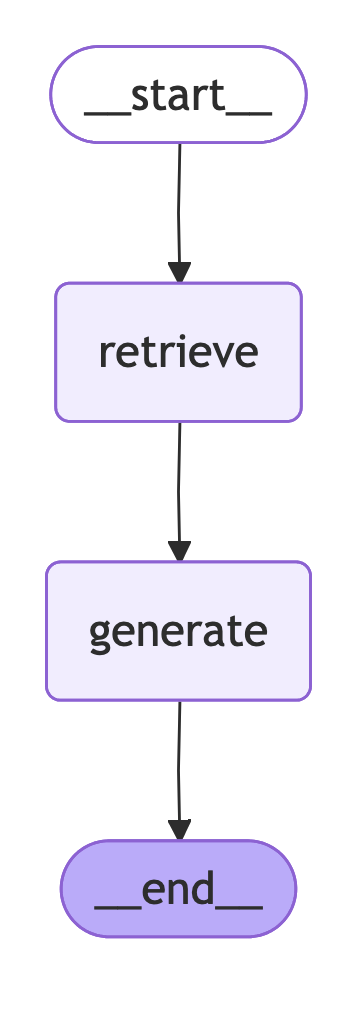

In [33]:
#graph
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Markdown, display, Image

data=graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(data))

Let's take it for a spin!

We invoke our graph like we do any other Runnable in LCEL!

> NOTE: That's right, even a compiled graph is a Runnable!

In [34]:
from IPython.display import Markdown, display
response = graph.invoke({"question" : "What are the most common ways people use AI in their work?"})
display(Markdown(response["response"]))

<think>
Okay, the user is asking about the most common ways people use AI in their work, and they want me to use the provided context to answer. Let me look through the documents given.

First, looking at the page 30 content: it mentions Panel A. Work Related, Panel B1. Asking, B2. Doing, B3. Expressing. So these panels might categorize different uses. Then on page 34, there's Panel A. Work Related again, and Panel B1. Asking, B2. Doing. Maybe these panels are part of a figure or table discussing different categories of AI use.

On page 53, there's an example of users rewriting emails, complaining about family, or asking for help with technical issues. These examples might fall under the categories mentioned in the panels. The mention of "IWA classifications" with two annotators could relate to categorizing these uses.

Page 37 talks about knowledge-intensive jobs where productivity increases with decision-making quality. That suggests AI is used to enhance decision-making in such roles. Page 39 references a study about underreporting AI use due to social desirability bias, but that's more about reporting than usage patterns.

Putting this together, the common ways might be: 1. Asking for help (like technical issues), 2. Doing tasks (like rewriting emails), 3. Expressing ideas (maybe through communication), and 4. Enhancing decision-making in knowledge work. The panels B1, B2, B3 under Work Related likely cover these areas. The examples on page 53 support these categories. So the answer should list these categories based on the panels and examples provided.
</think>

Based on the provided context, the most common ways people use AI in their work, as indicated in the document, include:

1. **Asking for assistance**: For example, users seek help with technical issues like fixing Python/Databricks errors or rewriting emails to communicate more effectively.  
2. **Performing tasks**: Activities such as rewriting emails, troubleshooting, or handling specific work-related queries (e.g., complaints or clarifications).  
3. **Enhancing decision-making**: AI is used in knowledge-intensive jobs to improve the quality of decisions and boost productivity.  
4. **Expressing ideas**: This may involve refining communication, such as making interactions with others (e.g., neighbors, family members) more friendly or effective.  

These categories are grouped under "Work Related" (Panel A) and subcategories like "Asking," "Doing," and "Expressing" (Panels B1–B3). The examples and classifications in the document highlight these patterns as prevalent AI usage scenarios in professional contexts.

In [35]:
response = graph.invoke({"question" : "Do people use AI for their personal lives?"})
display(Markdown(response["response"]))

<think>
Okay, the user is asking if people use AI for their personal lives. Let me check the provided context to find any relevant information.

Looking through the documents, there's a mention of "Panel B1. Asking." and "Panel B2. Doing." on page 30. Then on page 34, there's a reference to "Panel B3. Expressing." These panels might be categories of how people use AI. 

On page 53, there's an example where users are using AI for personal tasks like rewriting emails to neighbors about plumbing, complaining about family issues, or asking for help with technical problems. These examples clearly indicate personal use cases. 

Additionally, the document talks about "Interaction Quality" in figures 30 and 31, which might relate to how AI is used in personal interactions. The mention of "personal lives" in the examples provided on page 53 directly supports the idea that people use AI for personal purposes. 

Since the context includes specific examples of personal use, the answer should confirm that people do use AI for their personal lives.
</think>

Yes, people use AI for their personal lives. The context mentions examples such as rewriting emails to neighbors, complaining about family issues, and seeking help with technical problems like fixing Python databricks errors. These instances illustrate AI being used in personal contexts, such as communication, problem-solving, and daily tasks.

In [36]:
response = graph.invoke({"question" : "What concerns or challenges do people have when using AI?"})
display(Markdown(response["response"]))

<think>
Okay, let's tackle this query: "What concerns or challenges do people have when using AI?" The user wants me to use the provided context to answer, and if it's not there, say "I don't know."

First, I need to look through the given documents. Let me go through each one's page_content.

The first document mentions Panels A, B1, B2, and Figure 23, but it's on page 34. Not sure if that's relevant. The second document on page 30 has similar panels but also mentions Panel B3. Maybe these are sections of a report discussing AI usage, but they don't directly mention concerns or challenges.

The third document on page 39 has a citation about a paper titled "Underreporting of AI use: The role of social desirability bias." That sounds relevant. Social desirability bias could be a concern where people might not report their AI use truthfully because they think it's socially undesirable. That's a challenge in data collection.

Another document on page 37 talks about knowledge-intensive jobs and productivity increasing with decision-making quality. This might relate to challenges in integrating AI into work, but it's more about benefits than concerns.

The document on page 53 has examples of users rewriting emails, complaining about family, or asking for technical help. These examples might show how people use AI, but again, not directly addressing concerns or challenges. However, the mention of IWA classifications by annotators could relate to data annotation challenges, but that's a stretch.

Putting it together, the only direct mention of a concern is the social desirability bias from the paper cited on page 39. The other documents don't discuss specific concerns or challenges. So the answer should focus on that underreporting due to social desirability bias. I need to check if there's anything else, but I don't see other mentions of challenges. So the answer is about that bias, and maybe mention that other parts discuss usage scenarios but not specific concerns.
</think>

The provided context mentions a study titled *"Underreporting of AI use: The role of social desirability bias"* (cited on page 39), which highlights that people may underreport their AI usage due to social desirability bias. This suggests a challenge related to **social desirability bias** as a concern when using AI, where individuals might refrain from disclosing their AI use due to perceived societal norms or stigma. 

Other sections of the document describe usage scenarios (e.g., work-related tasks, asking for help, or expressing personal issues) but do not explicitly address additional concerns or challenges beyond this point. 

**Answer:**  
A noted concern is **social desirability bias**, where people may underreport their AI use due to societal perceptions. The context does not provide further details on other specific challenges.

In [37]:
response = graph.invoke({"question" : "Who is Batman?"})
display(Markdown(response["response"]))

<think>
Okay, let's see. The user is asking, "Who is Batman?" I need to check the provided context to see if there's any information about Batman.

Looking through the documents, they all seem to be related to a study or report about how people use ChatGPT. The pages mention things like work-related panels, asking, doing, expressing, and some figures about interaction quality and bias. There's also mention of LaTeX, PDF metadata, and some examples of user queries like rewriting emails or fixing Python errors. 

But wait, none of the page contents mention Batman. The documents are focused on AI usage, user interactions, and data analysis. There's no reference to fictional characters, superheroes, or any content related to Batman. The examples given are all about real-world tasks and technical issues. 

Since the context doesn't include any information about Batman, the correct response would be that I don't know. The user's query is outside the scope of the provided documents.
</think>

I don't know

#### ❓ Question #2:
LangGraph's graph-based approach lets us visualize and manage complex flows naturally. How could we extend our current implementation to handle edge cases? For example:
- What if the retriever finds no relevant context?  
- What if the response needs fact-checking?
Consider how you would modify the graph to handle these scenarios.

##### ✅ Answers
2.1 #See below

2.2 #See below

## 🎯 Answer 2.1: Handling no-context scenarios using conditional edges 

Let's implement a simple and efficient approach to handle cases when no relevant context is found using:
1. **LangGraph's conditional edges** for routing based on context availability
2. **Fallback response generation** when no context passes the threshold
3. **Qdrant's `score_threshold`** parameter for automatic relevance filtering 

This approach uses the existing embedding, chat, and vector store definitions from above.


In [76]:
# Enhanced State that includes context availability tracking
class EnhancedState(TypedDict):
    """State that tracks whether relevant context was found."""
    question: str
    context: list[Document]
    response: str
    has_relevant_context: bool  
    score_threshold: float


In [77]:
# Enhanced nodes for the conditional graph
def enhanced_retrieve(state: EnhancedState) -> dict:
    """
    Retrieve documents using score threshold and determine if context is relevant.
    """
    question = state["question"]
    

    # Use vector_store.similarity_search_with_score() - gets docs WITH scores!
    docs_with_scores = vector_store.similarity_search_with_score(
        query=question,
        k=5,
        score_threshold=state["score_threshold"]  # Apply threshold manually
    )
    
    for doc, score in docs_with_scores:
        print(f"📄 Score: {score:.4f} | Content: {doc.page_content[:80]}...")
 
    
    has_context = len(docs_with_scores) > 0
    print(f"✅ {len(docs_with_scores)} documents above threshold {state['score_threshold']}")
    
    # Return partial state update - LangGraph will merge with existing state
    return {
        "context": [doc for doc, _ in docs_with_scores],
        "has_relevant_context": has_context
    }

def generate_with_context(state: EnhancedState) -> dict:
    """Generate response using retrieved context."""
    
    # Format context for the prompt
    context_text = "\n\n".join([doc.page_content for doc in state["context"]])

    generator_chain = chat_prompt | ollama_chat_model | StrOutputParser()
    
    response = generator_chain.invoke({
        "query": state["question"],
        "context": context_text
    })
    
    print(f"✅ Generated response using {len(state['context'])} context documents")
    
    # Return partial state update
    return {"response": response}

def generate_fallback(state: EnhancedState) -> dict:
    """Generate fallback response when no relevant context is found."""
    question = state["question"]
    
    # Create fallback prompt
    fallback_prompt = ChatPromptTemplate.from_messages([
        ("human", """
        The user asked: "{question}"
        
        I don't have specific information about this topic in my knowledge base about how people use AI.
        Please provide a polite response explaining that you don't have information about this specific topic
        and suggest the user ask about topics related to "How People Use AI" since that's what the knowledge base contains.
        
        Keep the response helpful and concise.
        """)
    ])
    
    fallback_chain = fallback_prompt | ollama_chat_model | StrOutputParser()
    response = fallback_chain.invoke({"question": question})
    
    print("🔄 Generated fallback response (no relevant context found)")
    
    # Return partial state update
    return {"response": response}


In [ ]:
# Conditional edge function - this is the key to routing!
def route_based_on_context(state: EnhancedState) -> str:
    """
    Conditional edge function that routes based on context availability. This will NOT update the state.
    
    Args:
        state: Current state
        
    Returns:
        Next node name based on whether context was found
    """
    if state["has_relevant_context"]:
        print("🎯 Routing to: generate_with_context node")
        return "generate_with_context"
    else:
        print("🔄 Routing to: generate_fallback node")
        return "generate_fallback"


In [83]:
# Import END node
from langgraph.graph import END

# Build the enhanced graph with conditional edges
enhanced_graph_builder = StateGraph(EnhancedState)

# Add nodes
enhanced_graph_builder.add_node("enhanced_retrieve", enhanced_retrieve)
enhanced_graph_builder.add_node("generate_with_context", generate_with_context)
enhanced_graph_builder.add_node("generate_fallback", generate_fallback)

# Add edges
enhanced_graph_builder.add_edge(START, "enhanced_retrieve")

# Add conditional edge - this is the key feature!
enhanced_graph_builder.add_conditional_edges(
    "enhanced_retrieve",  # From node
    route_based_on_context,  
    {
        "generate_with_context": "generate_with_context",
        "generate_fallback": "generate_fallback"
    }
)

# Both generation nodes lead to END (not needed but explicitly added)
enhanced_graph_builder.add_edge("generate_with_context", END)
enhanced_graph_builder.add_edge("generate_fallback", END)

# Compile the graph
enhanced_graph = enhanced_graph_builder.compile()

print("✅ Enhanced graph built successfully!")
print("📋 Graph structure:")
print("   START → enhanced_retrieve → [conditional routing] → (generate_with_context OR generate_fallback) → END")


✅ Enhanced graph built successfully!
📋 Graph structure:
   START → enhanced_retrieve → [conditional routing] → (generate_with_context OR generate_fallback) → END


🎨 Enhanced RAG Graph with Conditional Edges:
This graph automatically routes based on whether relevant context is found


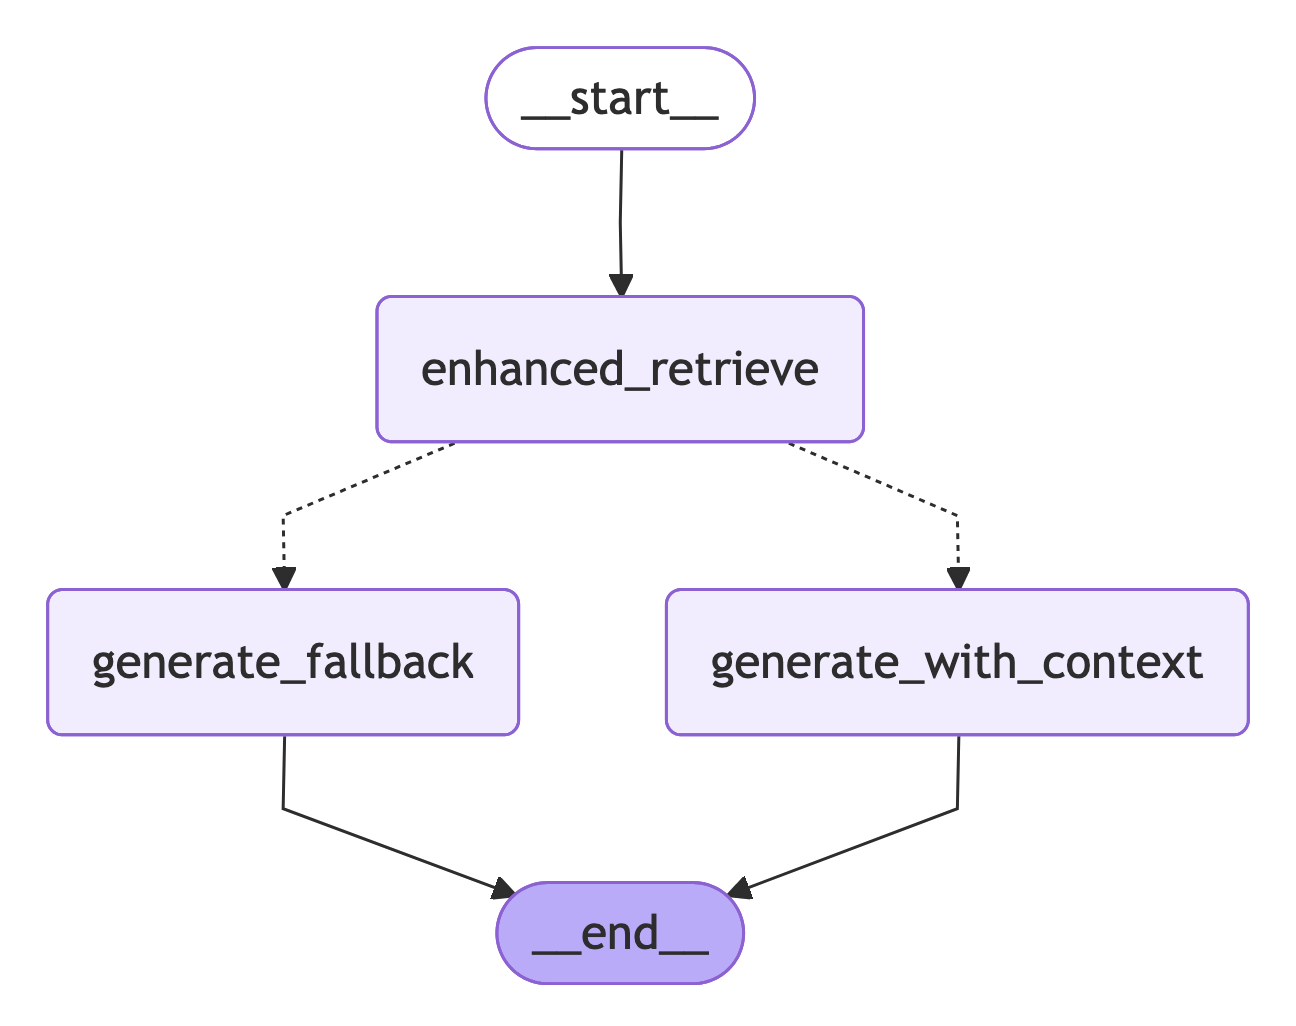

In [84]:
# Visualize the enhanced graph
print("🎨 Enhanced RAG Graph with Conditional Edges:")
print("This graph automatically routes based on whether relevant context is found")
graph_data = enhanced_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(graph_data))



#### 🧪 Test Examples: Demonstrating the Enhanced RAG System

Let's test our enhanced system with different scenarios to show how it handles both relevant and irrelevant queries.


In [152]:
# Test Case 1: Question likely to find relevant context
print("="*60)
print("🧪 TEST CASE 1: Question with Expected Relevant Context")
print("="*60)

question = "How do people use ChatGPT in their work?"
print(f"Question: {question}")
print("Expected: Should find relevant context and generate response\n")

result1 = enhanced_graph.invoke({
    "question": question,
    "score_threshold": 0.5,
})

print(f"✅ Context Found: {result1['has_relevant_context']}")
print(f"📄 Number of Context Documents: {len(result1['context'])}")
print(f"💬 Response: {result1['response']}")
print()


🧪 TEST CASE 1: Question with Expected Relevant Context
Question: How do people use ChatGPT in their work?
Expected: Should find relevant context and generate response

📄 Score: 0.6555 | Content: Panel A. Work Related
Panel B1. Asking.
Panel B2. Doing.
Figure 23: (continued o...
📄 Score: 0.6555 | Content: Panel A. Work Related
Panel B1. Asking.
Panel B2. Doing.
Figure 23: (continued o...
📄 Score: 0.6421 | Content: Panel A. Work Related
Panel B1. Asking.
Panel B2. Doing.
Panel B3. Expressing.
F...
📄 Score: 0.6421 | Content: Panel A. Work Related
Panel B1. Asking.
Panel B2. Doing.
Panel B3. Expressing.
F...
📄 Score: 0.6226 | Content: E.g. 'User is rewriting email to neighbors about
plumbing to be more friendly,'
...
✅ 5 documents above threshold 0.5
🎯 Routing to: generate_with_context node
✅ Generated response using 5 context documents
✅ Context Found: True
📄 Number of Context Documents: 5
💬 Response: <think>
Okay, let me try to figure out how to answer the user's query using the provided

In [ ]:
# Test Case 2: Question unlikely to find relevant context
print("="*60)
print("🧪 TEST CASE 2: Question with No Expected Relevant Context")
print("="*60)


question = "What are the ingredients for chocolate cake?"

print(f"Question: {question}")
print("Expected: Should NOT find relevant context and use fallback\n")


result2 = enhanced_graph.invoke(
    {
        "question": question,
        "score_threshold": 0.7,
    }
)

print(f"❌ Context Found: {result2['has_relevant_context']}")
print(f"📄 Number of Context Documents: {len(result2['context'])}")
print(f"🔄 Fallback Response: {result2['response']}")


🧪 TEST CASE 2: Question with No Expected Relevant Context
Question: 'What is the weather like today?'
Expected: Should NOT find relevant context and use fallback

✅ 0 documents above threshold 0.7
🔄 Routing to: generate_fallback node
🔄 Generated fallback response (no relevant context found)
❌ Context Found: False
📄 Number of Context Documents: 0
🔄 Fallback Response: <think>
Okay, the user asked for the ingredients of chocolate cake, but I don't have that info in my knowledge base. I need to politely explain that and redirect them to topics related to "How People Use AI." Let me make sure the response is helpful and concise. Maybe start by acknowledging their question, state that I can't provide the recipe, and then suggest they ask about AI usage topics. Keep it friendly and clear.
</think>

I don’t have specific information about chocolate cake ingredients, as my knowledge base focuses on topics related to *how people use AI*. Let me know if you’d like to explore those! 😊


### 📝 Summary for Answer 2.1: Enhanced RAG with Conditional Edges

### ✅ What I Implemented

1. **Score Threshold Filtering**: Used Qdrant's `score_threshold` parameter to automatically filter irrelevant documents
2. **Enhanced State**: Added `has_relevant_context` field to track context availability
3. **Conditional Routing**: Implemented LangGraph conditional edges to route based on context availability
4. **Fallback Strategy**: Created a dedicated fallback response when no relevant context is found

### 🔑 Key Benefits

- **Automatic Quality Control**: Score threshold ensures only relevant context is used
- **Graceful Degradation**: System provides helpful fallback responses instead of hallucinating
- **Simple Architecture**: Uses existing components with minimal additional complexity
- **Configurable**: Easy to adjust threshold based on use case requirements

### 🎯 When to Use This Approach

- **Production RAG Systems**: When you need reliable quality control
- **Domain-Specific Applications**: When irrelevant context could mislead users
- **Customer-Facing Systems**: When user experience requires consistent, honest responses

### 🔧 Customization Options

- Adjust `score_threshold` (0.0-1.0) based on precision/recall needs
- Modify fallback prompt to match your application's tone
- Add additional routing conditions (e.g., confidence scores, document count)
- Implement retry logic with different parameters

This approach provides a simple yet effective solution for handling the "no relevant context" scenario in RAG systems!


## 🎯 Answer 2.2: Simple fact-checking strategy along with enhancements in 2.1 

We'll implement a straightforward approach that checks if responses need verification based on simple criteria:

1. **Check for uncertainty words** - "might", "could", "possibly", etc.
2. **Detect unsupported claims** - statements not clearly backed by context
3. **Route based on confidence** - send uncertain responses for improvement


### 🎯 Structured Flow: Context First, Then Fact-Check

Let's create a cleaner implementation with **two separate conditional routing points**:

1. **Context Check**: Route to fallback if no context, otherwise continue to generation
2. **Fact-Check**: Route to improvement if uncertain, otherwise pass through

This creates a clear decision tree structure:

```
retrieve → [has context?] → generate → [needs fact-check?] → final_response
              ↓ (no)                      ↓ (yes)
           fallback                   improve_response
              ↓                           ↓
             END                         END
```


In [142]:
# Structured Flow State
class StructuredFlowState(TypedDict):
    question: str
    context: list[Document]
    response: str
    has_relevant_context: bool
    score_threshold: float
    needs_fact_check: bool
    final_response: str

In [156]:
# Simple fact-checking functions (redefine for this cell)
def simple_fact_check_needed(response: str) -> bool:
    """Simple heuristic to determine if a response needs fact-checking."""
    uncertainty_words = [
        'might', 'could', 'possibly', 'perhaps', 'maybe', 
        'seems', 'appears', 'likely', 'probably', 'unclear',
        'unsure', 'uncertain', 'not entirely sure'
    ]
    
    response_lower = response.lower()
    has_uncertainty = any(word in response_lower for word in uncertainty_words)
    has_dont_know = any(phrase in response_lower for phrase in ['don\'t know', 'not sure', 'cannot say'])
    
    return has_uncertainty and not has_dont_know


def structured_retrieve(state: StructuredFlowState) -> dict:
    """Step 1: Retrieve documents with enhanced logging."""
    question = state["question"]
    
    docs_with_scores = vector_store.similarity_search_with_score(
        query=question,
        k=10,
        score_threshold=state["score_threshold"]
    )
    
    for doc, score in docs_with_scores:
        print(f"📄 Score: {score:.4f} | Content: {doc.page_content[:80]}...")
    
    has_context = len(docs_with_scores) > 0
    print(f"✅ {len(docs_with_scores)} documents above threshold {state['score_threshold']}")
    
    return {
        "context": [doc for doc, _ in docs_with_scores],
        "has_relevant_context": has_context
    }


def structured_generate_fallback(state: StructuredFlowState) -> dict:
    """Step 2 Alternative: Generate fallback when no context."""
    fallback_prompt = ChatPromptTemplate.from_messages([
        ("human", """
        The user asked: "{question}"
        
        I don't have specific information about this topic in my knowledge base about how people use AI.
        Please provide a polite response explaining that you don't have information about this specific topic
        and suggest the user ask about topics related to "How People Use AI".
        """)
    ])
    
    fallback_chain = fallback_prompt | ollama_chat_model | StrOutputParser()
    response = fallback_chain.invoke({"question": state["question"]})
    
    print("🔄 Generated fallback response (no relevant context found)")
    
    return {
        "response": response,
        "needs_fact_check": False,  # Fallback doesn't need fact-checking
        "final_response": response  # Set final response directly
    }

def structured_generate_with_context(state: StructuredFlowState) -> dict:
    """Step 2: Generate response using context and check if fact-checking needed."""
    context_text = "\n\n".join([doc.page_content for doc in state["context"]])
    
    generator_chain = chat_prompt | ollama_chat_model | StrOutputParser()
    response = generator_chain.invoke({
        "query": state["question"],
        "context": context_text
    })
    
    # Check if fact-checking is needed
    needs_check = simple_fact_check_needed(response)
    
    print(f"✅ Generated response using {len(state['context'])} context documents")
    print(f"🔍 Needs fact-checking: {needs_check}")
    
    return {
        "response": response,
        "needs_fact_check": needs_check
    }

In [ ]:
def structured_improve_response(state: StructuredFlowState) -> dict:
    """Step 3a: Improve response that needs fact-checking."""
    """Simple response improvement that adds confidence qualifiers."""
    
    response = state["response"]
    improve_prompt = ChatPromptTemplate.from_messages([
        ("human", """
        Original response: {response}
        
        This response was flagged as potentially needing fact-checking.
        Please improve it by adding appropriate confidence qualifiers where needed
        and being more explicit about what the source material says.
        
        Improved response:
        """)
    ])
    
    improve_chain = improve_prompt | ollama_chat_model | StrOutputParser()
    
    print("🔧 Improved response with fact-checking")
    return {"final_response": improve_chain.invoke({"response": response})}

def structured_pass_through_response(state: StructuredFlowState) -> dict:
    """Step 3b: Pass through response that doesn't need fact-checking."""
    print("✅ Response passed fact-check - using original")
    return {"final_response": state["response"]}

# Conditional routing functions
def route_context_check(state: StructuredFlowState) -> str:
    """First routing: Check if we have context."""
    if state["has_relevant_context"]:
        print("🎯 Context found - routing to generation")
        return "generate_with_context"
    else:
        print("❌ No context found - routing to fallback")
        return "generate_fallback"

def route_fact_check(state: StructuredFlowState) -> str:
    """Second routing: Check if fact-checking needed."""
    if state["needs_fact_check"]:
        print("🔍 Fact-checking needed - routing to improvement")
        return "improve_response"
    else:
        print("✅ No fact-checking needed - routing to pass-through")
        return "pass_through_response"


In [ ]:
# Build the Structured Flow Graph with TWO conditional routing points
structured_graph = StateGraph(StructuredFlowState)

# Add all nodes
structured_graph.add_node("retrieve", structured_retrieve)
structured_graph.add_node("generate_with_context", structured_generate_with_context)
structured_graph.add_node("generate_fallback", structured_generate_fallback)
structured_graph.add_node("improve_response", structured_improve_response)
structured_graph.add_node("pass_through_response", structured_pass_through_response)

# Step 1: START → retrieve
structured_graph.add_edge(START, "retrieve")

# Step 2: FIRST conditional routing - check for context
structured_graph.add_conditional_edges(
    "retrieve",
    route_context_check,
    {
        "generate_with_context": "generate_with_context", 
        "generate_fallback": "generate_fallback"
    }
)

# Step 3: Fallback goes straight to END (no fact-checking needed)
structured_graph.add_edge("generate_fallback", END)

# Step 4: SECOND conditional routing - fact-checking for context-based responses
structured_graph.add_conditional_edges(
    "generate_with_context",
    route_fact_check,
    {
        "improve_response": "improve_response",
        "pass_through_response": "pass_through_response"
    }
)

# Step 5: Both fact-check paths go to END
structured_graph.add_edge("improve_response", END)
structured_graph.add_edge("pass_through_response", END)

# Compile the structured graph
structured_flow_graph = structured_graph.compile()

print("✅ Structured Flow RAG Graph built successfully!")
print("\n🎯 Flow Structure:")
print("1. retrieve → [has context?]")
print("   ├─ NO  → generate_fallback → END")
print("   └─ YES → generate_with_context → [needs fact-check?]")
print("                                    ├─ YES → improve_response → END")
print("                                    └─ NO  → pass_through_response → END")


✅ Structured Flow RAG Graph built successfully!

🎯 Flow Structure:
1. retrieve → [has context?]
   ├─ NO  → generate_fallback → END
   └─ YES → generate_with_context → [needs fact-check?]
                                    ├─ YES → improve_response → END
                                    └─ NO  → pass_through_response → END


🎨 Structured Flow RAG Graph with Two Conditional Routing Points:


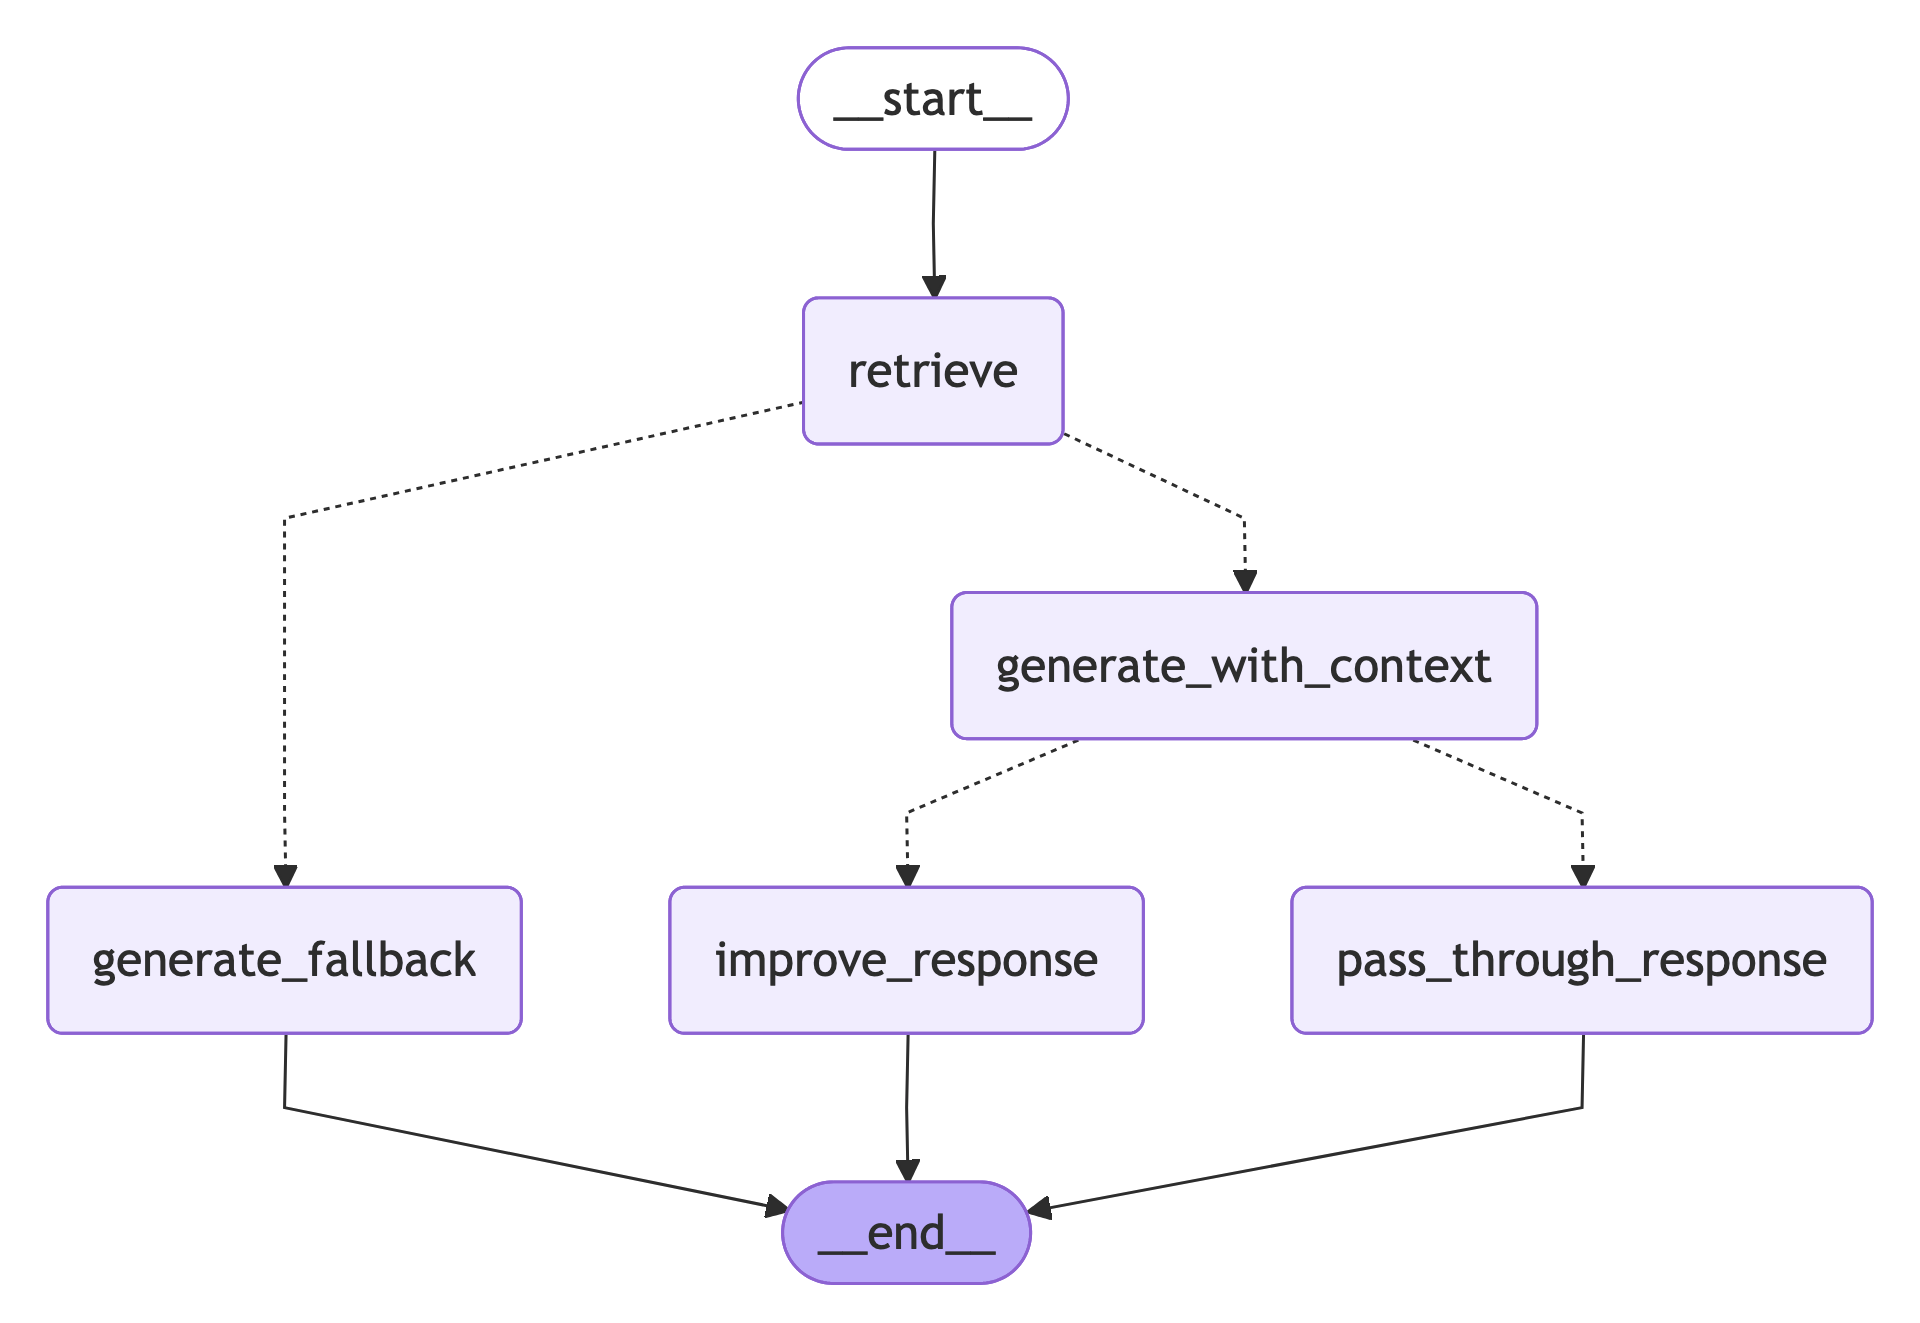

In [146]:
# Visualize the Structured Flow Graph
print("🎨 Structured Flow RAG Graph with Two Conditional Routing Points:")
structured_graph_data = structured_flow_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(structured_graph_data))

In [154]:
# Test the Structured Flow System
print("="*70)
print("🧪 TESTING STRUCTURED FLOW: Context Check → Fact-Check")
print("="*70)

# Test Case 1: Question with context that needs fact-checking
question = "What are the global patterns of ChatGPT usage showing explicit evidence?"
print("\n📝 Test 1: Question with context + uncertainty")
print(f"Question: {question}")
print("Expected: Context found → Generate → Fact-check needed → Improve")

result1 = structured_flow_graph.invoke({
    "question": question,
    "score_threshold": 0.4,
})

print(f"✅ Has Context: {result1['has_relevant_context']}")
print(f"🔍 Needed Fact-Check: {result1['needs_fact_check']}")
print(f"💬 Final Response: {result1['final_response']}")

print("\n" + "="*70)


🧪 TESTING STRUCTURED FLOW: Context Check → Fact-Check

📝 Test 1: Question with context + uncertainty
Question: What are the global patterns of ChatGPT usage showing explicit evidence?
Expected: Context found → Generate → Fact-check needed → Improve
📄 Score: 0.6080 | Content: Panel A. Work Related
Panel B1. Asking.
Panel B2. Doing.
Figure 23: (continued o...
📄 Score: 0.6080 | Content: Panel A. Work Related
Panel B1. Asking.
Panel B2. Doing.
Figure 23: (continued o...
📄 Score: 0.6021 | Content: Panel A. Work Related
Panel B1. Asking.
Panel B2. Doing.
Panel B3. Expressing.
F...
📄 Score: 0.6021 | Content: Panel A. Work Related
Panel B1. Asking.
Panel B2. Doing.
Panel B3. Expressing.
F...
📄 Score: 0.5951 | Content: 27As discussed in Section: Data and Privacy, our dataset only includes users on ...
📄 Score: 0.5951 | Content: 27As discussed in Section: Data and Privacy, our dataset only includes users on ...
📄 Score: 0.5871 | Content: in knowledge-intensive jobs where productivity is increasi

### 📝 Summary for Answer 2.2: Structured Flow with Two Conditional Routing Points

This implementation creates the exact flow you requested:

#### ✅ **Clear Decision Tree Structure**

1. **Context Check First**: 
   ```
   retrieve → [has context?] 
       ├─ NO  → fallback → END
       └─ YES → continue to generation
   ```

2. **Fact-Check Second** (only if context exists):
   ```
   generate → [needs fact-check?]
       ├─ YES → improve → END  
       └─ NO  → pass_through → END
   ```

#### 🎯 **Key Benefits**

- **Clean Separation**: Each conditional routing point has a single responsibility
- **Efficient Path**: No-context questions skip fact-checking entirely
- **Clear Logic**: Easy to understand and debug each decision point
- **Extensible**: Easy to add more conditions at each routing point

#### 🔄 **Three Possible Paths**

1. **No Context Path**: `retrieve → fallback → END`
2. **Context + Fact-Check Path**: `retrieve → generate → improve → END`  
3. **Context + Pass-Through Path**: `retrieve → generate → pass_through → END`

This structured approach provides clear separation of concerns while maintaining the enhanced retrieval capabilities and fact-checking functionality!
